In [102]:
import torch
import numpy as np
import os

# PyTorch uses 'nn.Module' as the base class for all neural network modules.
class TBHNN(torch.nn.Module):
    """
    Tight-binding Hamiltonian neural network
    """

    def __init__(self):
        super(TBHNN, self).__init__()
        self.H_size_added = 0
        # We will add more attributes and initializations as we convert other methods

    # Placeholder for read_training_set method, will be filled in later
    def read_training_set(self, references, k_vectors):
        num_k, num_b = references.shape
        self.num_b = num_b
        self.num_k = num_k
        self.H_size_init = num_b
        self.H_size = num_b
        self.references = torch.tensor(references, dtype=torch.float32, requires_grad=True)
        self.k_vectors = torch.tensor(k_vectors, dtype=torch.float32, requires_grad=True)
        # In PyTorch, tensors are automatically placed on the default device, so we don't
        # need to explicitly define device placement as in TensorFlow
        pass

    # Placeholder for define_TB_representation method, will be filled in later
    def define_TB_representation(self, vectors_without_opposite):
        # In PyTorch, we usually do not need to cast to complex inside class methods,
        # unless it is necessary for certain operations.
        num_r = len(vectors_without_opposite)
        self.num_r = num_r
        self.R = torch.nn.Parameter(torch.zeros((num_r, 3), dtype=torch.float32))

        # Then you can create a new tensor for R without in-place operations
        new_R_values = []
        for i, vector in enumerate(vectors_without_opposite):
            if not np.all(np.isclose(vector, 0.0)):
                new_R_values.append(torch.tensor(vector, dtype=torch.float32))
            else:
                new_R_values.append(torch.zeros(3, dtype=torch.float32))

        # Now you can concatenate the list of tensors into a single tensor
        new_R = torch.stack(new_R_values)

        # If 'self.R' needs to maintain its gradient, you should replace it with 'new_R' like so:
        self.R = torch.nn.Parameter(new_R)

        self.R_without_opposite = vectors_without_opposite

        pass

    # Placeholder for reinitialize method, will be filled in later
    def reinitialize(self):
        self.H_R = torch.nn.ParameterList()  # Use ParameterList instead of ModuleList
        self.H_size = self.H_size_init + self.H_size_added

        for _ in self.R_without_opposite:
            H_tmp = torch.nn.Parameter(torch.randn((self.H_size, self.H_size), dtype=torch.float32) * 0.1)
            self.H_R.append(H_tmp)
        pass

    # Placeholder for compute_bands method, will be filled in later
    def compute_bands(self):
        reproduced_bands = torch.zeros((self.num_k, self.H_size), dtype=torch.float32)
        
        for i in range(self.num_k):
            K = torch.zeros((self.H_size, self.H_size), dtype=torch.complex64)
            for j, H_R_component in enumerate(self.H_R):
                exp_factor = torch.exp(-1j * np.pi * torch.matmul(self.k_vectors[i], self.R[j]))
                K += exp_factor * H_R_component
                
            # Eigenvalues are computed from the Hermitian part of K to ensure they are real
            eigenvalues, _ = torch.linalg.eigh(K + K.conj().T)
            reproduced_bands[i] = eigenvalues.real

        # Sort the bands and discard those not needed for loss computation
        reproduced_bands = reproduced_bands[:, :self.H_size_init]
        self.bandstructure = reproduced_bands

        return reproduced_bands

In [103]:
def main():

    rvectors_without_opposite = np.array([[0,0,0],[0,0,1],], dtype=np.int32) # in units of[a, b, c] (a, b, and c are the real-space basis vectors; [l, n, m] means the lattice vector l*a+n*b+m*c)
    # Load training data
    references = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
    k_vectors = np.load("./data/input/InSe Nanoribbon/InSe-kpoints.npy") # in units of 1/2pi*[ak, bk, ck] (ak, bk, and ck are the corresponding k-space basis vectors; [l, n, m] means the k-vector (l/2pi)*ak+(n/2pi)*bk+(m/2pi)*ck)
    max_training_steps = 10000
    threshold = 5e-5

    # Initialize the model
    tbhnn = TBHNN()
    tbhnn.read_training_set(references, k_vectors)
    tbhnn.define_TB_representation(rvectors_without_opposite)
    tbhnn.reinitialize()
    # Define the optimizer
    optimizer = torch.optim.Adam(tbhnn.parameters(), lr=0.001)

    # Training parameters for stochastic reseating
    reseating_interval = 5000  # Reset every 100 steps, for example
    reseating_std_dev = 2  # Standard deviation for the normal distribution when reseating
    reset_condition=1e-5
    past_loss=10000
    basis_added_step = 2
    # Training loop
    for step in range(max_training_steps):
        optimizer.zero_grad()
        
        # Compute the loss and perform backward pass
        reproduced_bands = tbhnn.compute_bands()
        loss = torch.nn.SmoothL1Loss()(reproduced_bands, tbhnn.references)
        loss.backward()
        optimizer.step()
        # Stochastic reseating
        if step%reseating_interval==0 and step>0 :
            tbhnn.H_size_added += basis_added_step
            tbhnn.reinitialize()
            print(f"Reseated model parameters at step {step}")
        

        # Print loss every 10 steps
        if step % 1000 == 0:
            past_loss=loss.item()
            print(f"Step {step}: Loss = {loss.item()}")

        # Check for convergence
        if loss.item() < threshold:
            print("Convergence reached.")
            break

    return reproduced_bands

if __name__ == "__main__":
    reproduced_bands = main()

Step 0: Loss = 0.6131107211112976
Step 1000: Loss = 0.004607040900737047
Step 2000: Loss = 0.004391070455312729
Step 3000: Loss = 0.0038283271715044975
Step 4000: Loss = 0.0037216288037598133
Convergence reached.


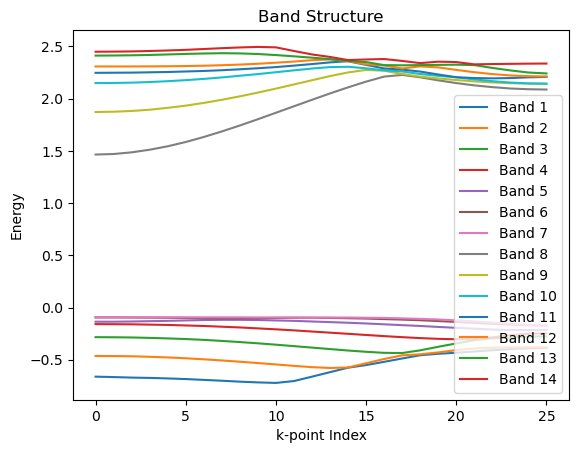

In [105]:
import matplotlib.pyplot as plt

# Convert the tensor to a NumPy array if it's not already (and detach it from the computation graph if it requires grad)
original_bands_np = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
# Assuming the horizontal axis is the band index and the vertical axis is the energy
for band in range(original_bands_np.shape[1]):
    plt.plot(original_bands_np[:, band], label=f'Band {band+1}')

plt.xlabel('k-point Index')
plt.ylabel('Energy')
plt.title('Band Structure')
plt.legend()
plt.show()

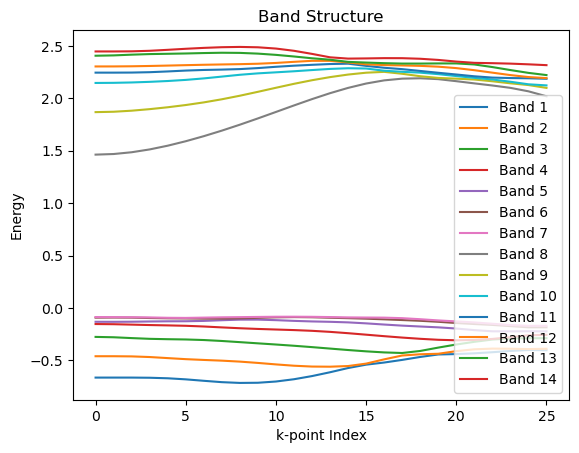

In [90]:


# Convert the tensor to a NumPy array if it's not already (and detach it from the computation graph if it requires grad)
reproduced_bands_np = reproduced_bands.detach().numpy()

# Assuming the horizontal axis is the band index and the vertical axis is the energy
for band in range(reproduced_bands_np.shape[1]):
    plt.plot(reproduced_bands_np[:, band], label=f'Band {band+1}')

plt.xlabel('k-point Index')
plt.ylabel('Energy')
plt.title('Band Structure')
plt.legend()
plt.show()